# FYS-STK4155 Project 3

This notebook contains all relevant code for the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as sklne
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import tensorflow as tf
import seaborn as sns
import scikitplot as sklplt
import sklearn.metrics as sklme
import tensorflow_addons as tfa
import xgboost as xgb
import sklearn.decomposition as sklde
import skopt
import joblib

#Setting font styles for plots.
fonts = {
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

plt.rcParams.update(fonts)

np.random.seed(123)

/Users/bernhard/.local/share/virtualenvs/FYS-STK4155-project3-MquKe0Ri/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Black for Jupyter Notebook!
%load_ext nb_black

<IPython.core.display.Javascript object>

## Preprocessing data
Using 0.33 of the data as test set.

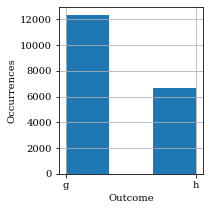

<IPython.core.display.Javascript object>

In [3]:
# Reading data
df = pd.read_csv("data/telescope_data.csv")
# Dropping useless column
df.drop("Unnamed: 0", axis=1, inplace=True)
# Setting feature matrix X and outcome y
X = df.drop("class", axis=1)
y = df["class"]

# Splitting
X_train, X_test, y_train, y_test = sklms.train_test_split(
    X, y, stratify=y, test_size=0.33
)

# Scaling feature matrix (All features are scalar).
scaler = sklpre.StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns
)
X_test = pd.DataFrame(scaler.transform(X_test.to_numpy()), columns=X_test.columns)

# One-hot encoding outcomes, keeping them as dataframes
encoder = sklpre.OneHotEncoder(categories="auto", sparse=False)
# Plotting histogram of outcomes
fig, ax = plt.subplots(figsize=(3.01682, 3.01682))
y.hist(ax=ax, density=False, bins=3)

y_train = pd.DataFrame(
    encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
y_test = pd.DataFrame(
    encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
ax.set_xlabel("Outcome")
ax.set_ylabel("Occurrences")
fig.tight_layout()
fig.savefig("../doc/figures/histogram.pdf", dpi=1000)
plt.show()
# Deleting non-used objects to avoid bugs later and save memory
del X
del y
del df

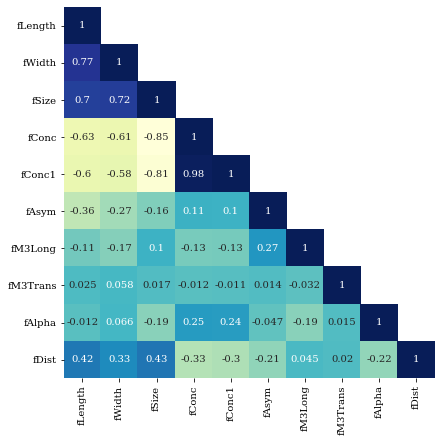

<IPython.core.display.Javascript object>

In [23]:
# Plotting correlation matrix, using mask to only show lower triangle because
# showing the entire matrix is unnecessary.
fig, ax = plt.subplots(figsize=(6.24123, 6.24123))
X_train_corr = X_train.corr()
mask = np.triu(X_train_corr, k=1)
mask = np.ma.array(X_train_corr.to_numpy(), mask=mask)
X_train_corr = pd.DataFrame(
    mask, columns=X_train_corr.columns, index=X_train_corr.index,
)
sns.heatmap(X_train_corr, cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False)
ax.set_ylim([10, 0])
ax.set_xlim([0, 10])
fig.tight_layout()
fig.savefig("../doc/figures/correlation_matrix_train.pdf", dpi=1000)
plt.show()

## kNN
Tuning k for kNN using 5-fold cross validation.

In [5]:
knn_base = sklne.KNeighborsClassifier()

hyperparams_knn = {"n_neighbors": np.arange(1, 50)}
# Using cross validation on train set to fit kNN and k.
grid_search_knn = sklms.GridSearchCV(
    knn_base,
    hyperparams_knn,
    scoring="f1_weighted",
    cv=5,
    iid=False,
    n_jobs=-1,
    verbose=0,
).fit(X_train, y_train)

<IPython.core.display.Javascript object>

k-NN:
Train weighted f1 score: 0.88
Test weighted f1 score: 0.83
Best k = 5


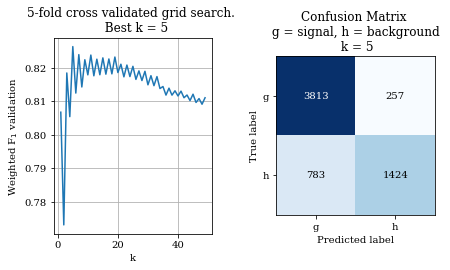

<IPython.core.display.Javascript object>

In [6]:
print("k-NN:")
print(f"Train weighted f1 score: {grid_search_knn.score(X_train, y_train):.2f}")
print(f"Test weighted f1 score: {grid_search_knn.score(X_test, y_test):.2f}")
print(f"Best k = {grid_search_knn.best_params_['n_neighbors']}")
fig, ax = plt.subplots(1, 2, figsize=[6.24123, 6.24123 / 1.618])
y_pred_test = encoder.inverse_transform(grid_search_knn.predict(X_test))
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    y_pred_test,
    ax=ax[1],
    hide_counts=False,
    normalize=False,
    title=f"Confusion Matrix "
    + f"\n g = signal, h = background "
    + f"\n k = {grid_search_knn.best_params_['n_neighbors']}",
)
# Scikit-plot doesn't let you disable colorbar, removing it manually
im = ax[1].images
cb = im[-1].colorbar
cb.remove()
ax[1].set_ylim([1.5, -0.5])
ax[1].set_xlim([-0.5, 1.5])
ax[0].plot(
    hyperparams_knn["n_neighbors"], grid_search_knn.cv_results_["mean_test_score"]
)
ax[0].set_xlabel("k")
ax[0].set_ylabel(r"Weighted F$_1$ validation")
ax[0].grid()
ax[0].set_title(
    f"5-fold cross validated grid search. \n  Best k = {grid_search_knn.best_params_['n_neighbors']}"
)
# fig.suptitle(fr"k Nearest Neighbors.")

fig.tight_layout()  # (rect=[0, 0.03, 1, 0.95])
fig.savefig("../doc/figures/kNN_cv_results.pdf", dpi=1000)
plt.show()

## Tensorflow neural network
Tuning hyperparameters using random search maximizing F$_1$ score. Splitting 0.1 of the train set into a validation set to use for tuning hyperparameters. After this, the model is refit on all the data using the best hyperparameters.

The reason we do not use cross validation in this case is computational cost. The "best" approach would obviousily be to use cross validation here as well though, as it gives a better estimate of expected prediction error.

In [26]:
# Creating validation split.
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

In [ ]:
# Scikit-optimize has built in distributions for finding hyperparameters using random search.
batch_sizes = skopt.space.Integer(low=1, high=200, name="batch_size")
dropout_1 = skopt.space.Real(low=0, high=0.5, name="dropout_1")
dropout_2 = skopt.space.Real(low=0, high=0.5, name="dropout_2")
nodes_1 = skopt.space.Integer(low=1, high=20, name="nodes_1")
nodes_2 = skopt.space.Integer(low=1, high=10, name="nodes_2")
space = [batch_sizes, dropout_1, dropout_2, nodes_1, nodes_2]

# Decorator provided by skopt, makes function usable by optimizers from the package.
@skopt.utils.use_named_args(dimensions=space)
def neural_network_fit(
    batch_size, dropout_1, dropout_2, nodes_1, nodes_2, return_epochs=False
):
    # Early stopping so we don't have to tune epochs as well.
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=1, restore_best_weights=True
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(nodes_1, activation="relu"),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(nodes_2, activation="relu"),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy",
    )

    model.fit(
        X_train_split,
        y_train_split,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=0,
        callbacks=[early_stop],
    )
    # This condition is True when we want to use the function to get best number of epochs.
    if return_epochs:
        return early_stop.stopped_epoch
    y_pred_validation_nn = model.predict_classes(X_validation).reshape(-1, 1)
    y_pred_validation_nn = np.append(
        y_pred_validation_nn == 0, y_pred_validation_nn == 1, axis=1
    ).astype(np.int)
    f1_score_weighted_validation = sklme.f1_score(
        y_true=y_validation, y_pred=y_pred_validation_nn, average="weighted"
    )

    return 1 - f1_score_weighted_validation

# !00 random points
n_points = 1000
optimizer_nn = skopt.gp_minimize(
    func=neural_network_fit,
    dimensions=space,
    n_jobs=-1,
    verbose=True,
    n_calls=n_points,
    n_random_starts=n_points,
)

### Refitting on full training set

In [ ]:
best_batch_nn = optimizer_nn["x"][0]
best_dropout_1 = optimizer_nn["x"][1]
best_dropout_2 = optimizer_nn["x"][2]
best_nodes_1 = optimizer_nn["x"][3]
best_nodes_2 = optimizer_nn["x"][4]
print(
    type(best_batch_nn),
    type(best_dropout_1),
    best_dropout_2,
    type(best_nodes_1),
    best_nodes_2,
)
# Finding best number of epochs.
best_epochs = neural_network_fit.__wrapped__(
    best_batch_nn, best_dropout_1, best_dropout_2, best_nodes_1, best_nodes_2, True,
)
print(best_epochs)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    epochs=best_epochs,
    batch_size=best_batch_nn,
    verbose=1,
)
# Saving model
model.save_weights("models/best_nn_not_pca")
np.save("models/best_hyperparams_nn.npy", optimizer_nn["x"])

Neural Network:
Train weighted f1 score: 0.87
Test weighted f1 score: 0.87
Best hyperparams: [1.09000000e+02 1.26008476e-01 9.46649301e-02 1.70000000e+01
 4.00000000e+00]


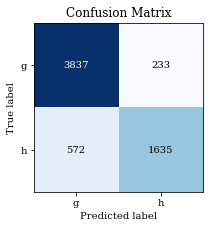

<IPython.core.display.Javascript object>

In [29]:
# Loading saved hyperparameters
best_hyperparams = np.load("models/best_hyperparams_nn.npy")
best_batch_nn = best_hyperparams[0]
best_dropout_1 = best_hyperparams[1]
best_dropout_2 = best_hyperparams[2]
best_nodes_1 = best_hyperparams[3]
best_nodes_2 = best_hyperparams[4]

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)
# Loading saved model
model.load_weights("models/best_nn_not_pca")

y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)


print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")
print(f"Best hyperparams: {best_hyperparams}")

fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

## XGBoost
Using randomized search to maximize F$_1$ score on validation set (0.1 of train set). Model is then refit on full training set using best hyperparameters.

In [30]:
# XGBoost wants the data in a different format.
y_train_boost = encoder.inverse_transform(y_train).ravel()
y_test_boost = encoder.inverse_transform(y_test).ravel()

y_train_split_boost = encoder.inverse_transform(y_train_split).ravel()
y_validation_boost = encoder.inverse_transform(y_validation).ravel()

validation_set_boost = [(X_validation, y_validation_boost)]

<IPython.core.display.Javascript object>

In [31]:
space_xg = [
    skopt.space.Real(low=1e-2, high=2e-1, prior="log-uniform", name="learning_rate"),
    skopt.space.Integer(low=1, high=10, name="max_tree_depth"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l1_alpha"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l2_lambda"),
    skopt.space.Integer(low=1, high=10, name="min_child_weight"),
]

<IPython.core.display.Javascript object>

In [32]:
@skopt.utils.use_named_args(dimensions=space_xg)
def xgboost_tune(
    learning_rate,
    max_tree_depth,
    l1_alpha,
    l2_lambda,
    min_child_weight,
    return_estimators=False,
):

    xgboost = xgb.XGBClassifier(
        objective="binary:logistic",
        n_jobs=-1,
        n_estimators=int(1e3),
        learning_rate=learning_rate,
        max_depth=max_tree_depth,
        reg_alpha=l1_alpha,
        reg_lambda=l2_lambda,
        min_child_weight=min_child_weight,
    ).fit(
        X=X_train_split,
        y=y_train_split_boost,
        eval_metric=["logloss"],
        eval_set=validation_set_boost,
        early_stopping_rounds=3,
        verbose=False,
    )

    y_pred_validation_boost = xgboost.predict(X_validation).reshape(-1, 1)
    f1_score_validation = sklme.f1_score(
        y_true=y_validation,
        y_pred=encoder.transform(y_pred_validation_boost),
        average="weighted",
    )
    
    # Same logic as with neural network, circumventing the need for tuning epochs.
    if return_estimators:
        return xgboost.best_iteration

    return 1 - f1_score_validation

<IPython.core.display.Javascript object>

In [ ]:
n_points_xg = 1000
optimizer_xgboost = skopt.gp_minimize(
    func=xgboost_tune,
    dimensions=space_xg,
    n_jobs=1,
    verbose=True,
    n_calls=n_points_xg,
    n_random_starts=n_points_xg,
)

In [34]:
(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
) = optimizer_xgboost["x"]

print(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
)

best_n_estimators = xgboost_tune.__wrapped__(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
    return_estimators=True,
)
print(best_n_estimators)

0.04816379830160162 9 0.007460566109135296 0.0035695005914375133 3
125


<IPython.core.display.Javascript object>

### Refitting on full train set.

In [35]:
xgboost_refit = xgb.XGBClassifier(
    objective="binary:logistic",
    n_jobs=-1,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_tree_depth,
    reg_alpha=best_l1_alpha,
    reg_lambda=best_l2_lambda,
    min_child_weight=best_min_child_weight,
    verbose=True,
).fit(X_train, y_train_boost)
# Saving
joblib.dump(xgboost_refit, "models/xgboost_refit.pkl")
np.save(
    "models/best_hyperparams_xgboost.npy",
    np.array(optimizer_xgboost["x"], dtype=object),
)

<IPython.core.display.Javascript object>

In [36]:
# Loading results.
best_hyperparams_xgboost = dict(
    zip(
        ["learning_rate", "max_depth", "reg_alpha", "reg_lambda", "min_child_weight",],
        np.load("models/best_hyperparams_xgboost.npy", allow_pickle=True),
    )
)
xgboost_refit = joblib.load("models/xgboost_refit.pkl")

<IPython.core.display.Javascript object>

XGBoost:
Train weighted f1 score: 0.95
Test weighted f1 score: 0.88


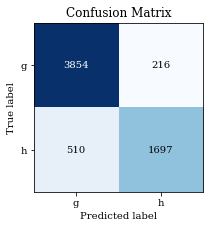

<IPython.core.display.Javascript object>

In [37]:
y_pred_train_boost = xgboost_refit.predict(X_train).reshape(-1, 1)
y_pred_test_boost = xgboost_refit.predict(X_test).reshape(-1, 1)

f1_score_weighted_train_boost = sklme.f1_score(
    y_true=y_train, y_pred=encoder.transform(y_pred_train_boost), average="weighted"
)

f1_score_weighted_test_boost = sklme.f1_score(
    y_true=y_test, y_pred=encoder.transform(y_pred_test_boost), average="weighted"
)

print("XGBoost:")
print(f"Train weighted f1 score: {f1_score_weighted_train_boost:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test_boost:.2f}")


fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()), y_pred_test_boost, ax=ax,
)

ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/xgboost_confusion_matrix.pdf", dpi=1000)
plt.show()